In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
# SQLite3 버전 문제 해결: Chroma는 SQLite3 3.35.0 이상이 필요하지만 시스템에는 낮은 버전이 설치되어 있음
# pysqlite3-binary를 사용하여 더 높은 버전의 SQLite3을 제공
import sys
import pysqlite3

# 기존 sqlite3 모듈을 pysqlite3으로 대체
sys.modules['sqlite3'] = pysqlite3
print(f"Using SQLite version: {pysqlite3.sqlite_version}")

Using SQLite version: 3.46.1


In [3]:
import chromadb
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

client = chromadb.PersistentClient('./brief')

embedding_function = OpenAIEmbeddings(model='text-embedding-3-large')

vector_store = Chroma(
    client=client,
    embedding_function=embedding_function,
    collection_name='brief'
)

retriever = vector_store.as_retriever(search_kwargs={"k": 3})

In [4]:
from typing_extensions import List, TypedDict
from langchain_core.documents import Document
from langgraph.graph import StateGraph


class AgentState(TypedDict):
    query: str
    context: List[Document]
    answer: str


graph_builder = StateGraph(AgentState)

In [5]:
def retrieve(state: AgentState):
    query = state['query']
    docs = retriever.invoke(query)
    return {'context': docs}

In [6]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o')

In [7]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

generate_prompt = hub.pull("rlm/rag-prompt")


def generate(state: AgentState):
    context = state['context']
    query = state['query']
    rag_chain = generate_prompt | llm | StrOutputParser()
    response = rag_chain.invoke({'context': context, 'question': query})
    return {'answer': response}


In [8]:
from langchain import hub
from typing import Literal

doc_relevance_prompt = hub.pull('langchain-ai/rag-document-relevance')


def check_doc_relevance(state: AgentState) -> Literal['relevant', 'irrelevant']:
    query = state['query']
    context = state['context']
    doc_relevance_chain = doc_relevance_prompt | llm
    response = doc_relevance_chain.invoke({'question': query, 'documents': context})
    if response['Score'] == 1:
        return 'relevant'

    return 'irrelevant'


In [9]:
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

rewrite_prompt = PromptTemplate.from_template("""
사용자의 질문을 보고, 웹 검색에 용이하게 사용자의 질문을 수정해주세요
질문: {query}
                                              """)


def rewrite(state: AgentState):
    query = state['query']
    rewrite_chain = rewrite_prompt | llm | StrOutputParser()
    response = rewrite_chain.invoke({'query': query})
    return {'query': response}

In [10]:
from langchain_community.tools import TavilySearchResults

tavily_search_tool = TavilySearchResults(
    max_results=3,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=True
)


def web_search(state: AgentState):
    query = state['query']
    results = tavily_search_tool.invoke(query)
    return {'context': results}

/tmp/ipykernel_4163668/1919484908.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_search_tool = TavilySearchResults(


In [11]:
graph_builder.add_node('retrieve', retrieve)
graph_builder.add_node('generate', generate)
graph_builder.add_node('rewrite', rewrite)
graph_builder.add_node('web_search', web_search)

In [12]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'retrieve')
graph_builder.add_conditional_edges(
    'retrieve',
    check_doc_relevance,
    {
        'relevant': 'generate',
        'irrelevant': 'rewrite'
    }
)

graph_builder.add_edge('rewrite', 'web_search')
graph_builder.add_edge('web_search', 'generate')
graph_builder.add_edge('generate', END)

In [13]:
graph = graph_builder.compile()

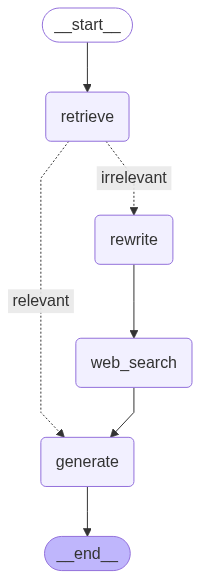

In [15]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [17]:
initial_state = {'query' : '삼성전자가 AI에 투자한 금액은 얼마인가요?'}
graph.invoke(initial_state)

{'query': '"삼성전자의 AI 투자 금액은 얼마인가요?"',
 'context': [{'title': '"삼성전자, 미국 로봇 스타트업 스킬드AI에 100억원대 투자" | 연합뉴스',
   'url': 'https://www.yna.co.kr/view/AKR20250612056200009',
   'content': '(서울=연합뉴스) 차병섭 기자 = 삼성전자가 미국 로봇 소프트웨어 스타트업인 스킬드AI에 1천만 달러(약 136억원)를 투자한다고 블룸버그 통신이 12일(현지시간) 복수의 익명 소식통을 인용해 보도했다.\n\n스킬드AI가 45억 달러(약 6조원) 수준의 기업 평가 가치를 바탕으로 진행 중인 시리즈B 자금 모집에 삼성전자가 참여해 소수 지분을 확보할 방침이라는 것이다.\n\n삼성전자 외에도 일본 소프트뱅크그룹이 1억 달러(약 1천368억원), 미국 반도체 업체 엔비디아는 2천500만 달러(약 342억원)가량을 각각 투자한다고 블룸버그는 전했다.\n\n삼성전자·엔비디아·스킬드AI 측은 블룸버그의 논평 요청에 입장을 밝히지 않았다.\n\nLG·한화·미래에셋 등 한국 대기업들이 스킬드AI에 500만∼1천만 달러(약 68억∼136억원) 규모로 투자 중인 점도 삼성전자가 스킬드AI에 대한 투자에 나선 배경으로 블룸버그는 분석했다. [...] # "삼성전자, 미국 로봇 스타트업 스킬드AI에 100억원대 투자"\n\n송고2025-06-12 10:19\n\n송고 2025년06월12일 10시19분\n\n삼성전자가 미국 로봇 소프트웨어 스타트업인 스킬드AI에 1천만 달러를 투자한다고 블룸버그 통신이 12일 복수의 익명 소식통을 인용해 보도했다.\n\nLG·한화·미래에셋 등 한국 대기업들이 스킬드AI에 500만∼1천만 달러 규모로 투자 중인 점도 삼성전자가 스킬드AI에 대한 투자에 나선 배경으로 블룸버그는 분석했다.\n\n애플·구글·테슬라 등 빅테크들이 로봇 산업을 미래 먹거리로 보고 대규모 투자를 이어가는 가운데, 삼성전자도 소비자용 로봇 산업에서 역량을 강